<a href="https://colab.research.google.com/github/Burningzabidan/kims/blob/main/%5B%E1%84%87%E1%85%A6%E1%84%8B%E1%85%A5%E1%84%85%E1%85%B5%E1%86%BC%E1%84%80%E1%85%AA%E1%84%8C%E1%85%A6%5D%E1%84%80%E1%85%A1%E1%86%BC%E1%84%83%E1%85%A9_%E1%84%8B%E1%85%A8%E1%84%8E%E1%85%B3%E1%86%A8_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models

import os
import cv2
from PIL import Image
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#1. 데이터 가져오기 및 전처리

In [89]:
### 인장 시험 데이터 가져오기

# load tensile test result
f = open("/content/tensile_test_result.txt","r")
lines = f.readlines()
new_lines = []

# \n, 공백 삭제
for line in lines:
  new_lines.append(re.sub('[\n| ]', '', line))

# df로 만들기
new_lines_np = np.array(new_lines).reshape(-1,6)
tensile_res = [[] for _ in range(4)]
for i in range(len(new_lines_np)):
  for j in new_lines_np[i]:
    if re.match('[가-힣]',j):
      if tensile_res[i%4] == []:
        tensile_res[i%4].append(j)
    else:
      tensile_res[i%4].append(j)

tensile_res = np.array(tensile_res).reshape(4,-1)
df_tensile_res = pd.DataFrame(tensile_res[1:,1:], index = tensile_res[1:,0])
df_tensile_res.columns = tensile_res[0,1:]
df_tensile_res

,1-1,1-2,1-3,1-4,1-5,2-1,2-2,2-3,2-4,2-5,...,4-1,4-2,4-3,4-4,4-5,5-1,5-2,5-3,5-4,5-5
인장강도N/mm2,1527,1439,1445,1421,1429,1200,1225,1256,1211,1253,...,1004,1004,1033,1019,994,896,882,918,897,928
항복강도(0.2%offset)N/mm2,1454,1359,1381,1354,1369,1113,1128,1186,1117,1170,...,907,902,927,916,896,816,780,826,831,845
연신율(GL:50mm)%,11,13,12,13,13,14,14,14,15,15,...,19,18,16,18,19,21,21,21,21,20


In [121]:
# 연결 리스트로 샘플 시리즈별 인장강도(TS), 항복강도(YS), 연신율(EL) 정리
properties = {}
for i in range(1,6):
  properties[i] = {}
  for j in ("TS", "YS", "EL"):
    properties[i][j] = []

for m in df_tensile_res.columns:
  for k,l in enumerate(["TS", "YS", "EL"]):
    p = df_tensile_res[m][k]
    properties[int(m[0])][l].append(p)

In [122]:
properties

{1: {'TS': ['1527', '1439', '1445', '1421', '1429'],
  'YS': ['1454', '1359', '1381', '1354', '1369'],
  'EL': ['11', '13', '12', '13', '13']},
 2: {'TS': ['1200', '1225', '1256', '1211', '1253'],
  'YS': ['1113', '1128', '1186', '1117', '1170'],
  'EL': ['14', '14', '14', '15', '15']},
 3: {'TS': ['1096', '1110', '1096', '1092', '1177'],
  'YS': ['991', '1014', '994', '989', '1089'],
  'EL': ['16', '16', '16', '17', '15']},
 4: {'TS': ['1004', '1004', '1033', '1019', '994'],
  'YS': ['907', '902', '927', '916', '896'],
  'EL': ['19', '18', '16', '18', '19']},
 5: {'TS': ['896', '882', '918', '897', '928'],
  'YS': ['816', '780', '826', '831', '845'],
  'EL': ['21', '21', '21', '21', '20']}}

(22, 960, 1280, 3)


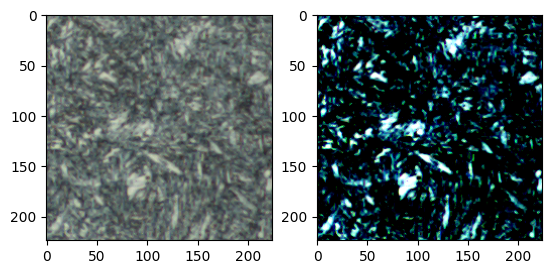

In [72]:
# 3차원 이미지 쌓아서 4차원으로
files = [cv2.imread(f) for f in os.listdir('./') if 'tif' in f ]
imgs = np.stack(tuple(files),axis = 0)/255
print(imgs.shape)

# 이미지를 224x224x3으로 크롭
n,h,w,c = imgs.shape
imgs_crop = np.empty((5000,224,224,3))
idx = 0
for i in range(n):
  for dx in range(0,h-224,112):
    for dy in range(0,w-224,112):
      imgs_crop[idx] = imgs[i][dx:dx+224, dy:dy+224]
      idx += 1
imgs_crop = imgs_crop[:idx]

# 이미지 정규화
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225],
    )]
)

# 크롭 및 정규화 체크
imgs_crop_end = transform(imgs_crop[-1])
fig,ax = plt.subplots(1,2)
ax[0].imshow(imgs_crop[-1])
ax[1].imshow(np.transpose(imgs_crop_end,(1,2,0)))

In [107]:
a = dict()
a[1] = {5:{"img":[], "ts":[], "ys":[], "el":[]}}

In [109]:
import random
random.choice(range(100,140))

124

#2. 모델링

In [ ]:
# loading resnet101
my_model = models.resnet101(pretrained = True)

# change in and out features of fc layer
in_features = my_model.fc.in_features
out_features = 1
my_model.fc = nn.Linear(in_features, out_features)

# freeze parameters when training
for params in my_model.parameters():
  params.requires_grad = False

# unfreeze parameters of fc layer when training
for params in my_model.fc.parameters():
  params.requires_grad = True

# model to device
my_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#3. 모델 훈련

In [ ]:
out = my_model(inp)
lr = 0.0001 # learning rate
optimizer = torch.optim.Adam(my_model.parameters(), lr=lr)
loss_fn = nn.MSELoss().to(device)